<a href="https://colab.research.google.com/github/afvallejo/CSHL2022/blob/main/2_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# link Gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install packages

In [2]:
%load_ext rpy2.ipython

In [ ]:
%%R
options(Ncpus = 8)
options(repos=structure(c(CRAN="http://cloud.r-project.org/")))
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
check.packages <- function(pkg){
    new.pkg <- pkg[!(pkg %in% installed.packages()[, "Package"])]
    if (length(new.pkg)) 
        BiocManager::install(new.pkg, dependencies = TRUE,suppressUpdates = T)
    sapply(pkg, require, character.only = TRUE)
}

# Usage
packages<-c('devtools','BiocManager','edgeR','limma','tximport','biomaRt', 'dplyr', 'tidyverse','ensembldb','EnsDb.Hsapiens.v86','rhdf5','genefilter')
check.packages(packages)

Streaming output truncated to the last 5000 lines.




































































































































































































































































































































































































































In [ ]:
!Rscript -e "options(Ncpus = 2)" -e "install.packages('devtools')" -e "install.packages('BiocManager')" -e "BiocManager::install(c('edgeR','limma','tximport','biomaRt', 'dplyr', 'tidyverse','ensembldb','EnsDb.Hsapiens.v86',rhdf5','genefilter'))" -e "devtools::install_github('pachterlab/sleuth')"

In [3]:
from rpy2.robjects.packages import importr
utils = importr('utils')
%load_ext rpy2.ipython

# Downloading the data

In [4]:
%%capture
%%!
wget https://www.dropbox.com/s/np2nebpdb6y9q6t/test_data.zip
unzip /content/test_data.zip test_data/

# Set WD

In [ ]:
%%R
setwd("/content/")

In [5]:
%ls

drive/        SRR6914400/  SRR6914402/  test_data.zip    test_data.zip.2
sample_data/  SRR6914401/  SRR6914403/  test_data.zip.1


# Load packages

In [ ]:
%%R
# Load all the R libraries we will be using in the notebook
library(tximport)
library(biomaRt)
library(Biobase)
library(ggplot2)
library(dplyr)
library(tidyverse) 
library(Biostrings)
library(ensembldb)
library(EnsDb.Hsapiens.v86) 
library(rhdf5)
library(genefilter)
library(RColorBrewer) 
library(reshape2)
library(edgeR)
library(matrixStats) 
library(sleuth) 

# Load the Data

In [ ]:
%%R
listTables(EnsDb.Hsapiens.v86)
listColumns(EnsDb.Hsapiens.v86, "tx")
Tx <- transcripts(EnsDb.Hsapiens.v86, columns=c(listColumns(EnsDb.Hsapiens.v86,"tx"), "gene_name"))
Tx <- as_tibble(Tx)
Tx <- dplyr::rename(Tx, target_id = tx_id)
Tx <- dplyr::select(Tx, target_id, gene_name)
print(dim(Tx))
head(Tx)

[1] 216741      2
# A tibble: 6 x 2
  target_id       gene_name
  <chr>           <chr>    
1 ENST00000456328 DDX11L1  
2 ENST00000450305 DDX11L1  
3 ENST00000488147 WASH7P   
4 ENST00000619216 MIR6859-1
5 ENST00000473358 MIR1302-2
6 ENST00000469289 MIR1302-2


In [ ]:
%%R
metadata <- matrix(c("sample1","SRR6914400","group1","sample2","SRR6914401",'group1',"sample3","SRR6914402",'group2',"sample4","SRR6914403",'group2'),ncol=3,byrow=TRUE)
colnames(metadata) <- c("sample","folder",'group')
metadata <- as.data.frame(metadata)
metadata

   sample     folder  group
1 sample1 SRR6914400 group1
2 sample2 SRR6914401 group1
3 sample3 SRR6914402 group2
4 sample4 SRR6914403 group2


In [ ]:
%%R
path <- file.path(metadata$folder, "abundance.h5")
all(file.exists(path)) 

[1] TRUE


In [ ]:
%%R
Txi_gene <- tximport(path, 
                     type = "kallisto", 
                     tx2gene = Tx, 
                     txOut = FALSE, #How does the result change if this =FALSE vs =TRUE?
                     countsFromAbundance = "lengthScaledTPM",
                     ignoreTxVersion=TRUE)

colSums(Txi_gene$counts)

R[write to console]: 1 
R[write to console]: 2 
R[write to console]: 3 
R[write to console]: 4 
R[write to console]: 

R[write to console]: transcripts missing from tx2gene: 9784

R[write to console]: summarizing abundance

R[write to console]: summarizing counts

R[write to console]: summarizing length



[1] 4152834 4136155 4689889 4043707


# Examine your data up to this point

In [ ]:
%%R
myTPM <- Txi_gene$abundance
myCounts <- Txi_gene$counts
colnames(myCounts) <- metadata$folder
colnames(myTPM) <- metadata$folder
print(colSums(myTPM))
colSums(myCounts)

SRR6914400 SRR6914401 SRR6914402 SRR6914403 
  960520.4   956082.7   957353.5   954376.1 
SRR6914400 SRR6914401 SRR6914402 SRR6914403 
   4152834    4136155    4689889    4043707 


## Generate summary stats for your data ----
- 1st, calculate summary stats for each transcript or gene, and add these to your data matrix
- then use the base R function 'transform' to modify the data matrix (equivalent of Excel's '=')

In [ ]:
%%R
myTPM.stats <- transform(myTPM, 
                         SD=rowSds(myTPM), 
                         AVG=rowMeans(myTPM),
                         MED=rowMedians(myTPM)
                         )

myCounts.stats <- transform(myCounts, 
                            SD=rowSds(myCounts), 
                            AVG=rowMeans(myCounts), 
                            MED=rowMedians(myCounts)
                            )
head(myTPM.stats)

         SRR6914400 SRR6914401 SRR6914402 SRR6914403         SD         AVG
5S_rRNA  0.00000000 0.00000000    0.00000  0.0000000  0.0000000  0.00000000
A1BG    23.67540528 0.80899392   63.91172  0.2473736 29.8972204 22.16087361
A1CF     0.00000000 0.09277740    0.00000  0.0000000  0.0463887  0.02319435
A2M      0.00000000 0.00000000    0.00000  0.0000000  0.0000000  0.00000000
A2ML1    0.06860954 0.06211528    0.40102  0.0000000  0.1813785  0.13293621
A2MP1    0.00000000 0.00000000    0.00000  0.0000000  0.0000000  0.00000000
                MED
5S_rRNA  0.00000000
A1BG    12.24219960
A1CF     0.00000000
A2M      0.00000000
A2ML1    0.06536241
A2MP1    0.00000000


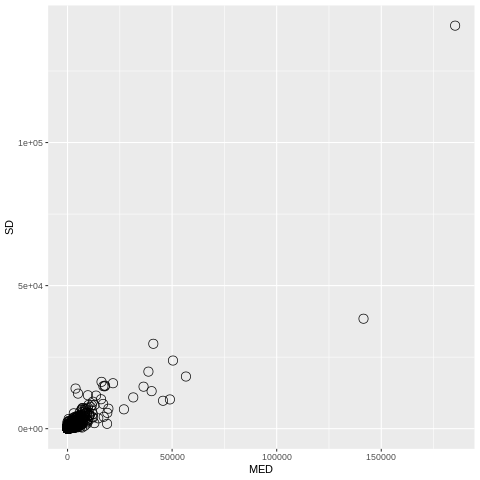

In [ ]:
%%R
 ggplot(myCounts.stats, aes(x=MED, y=SD)) +
  geom_point(shape=1, size=4)


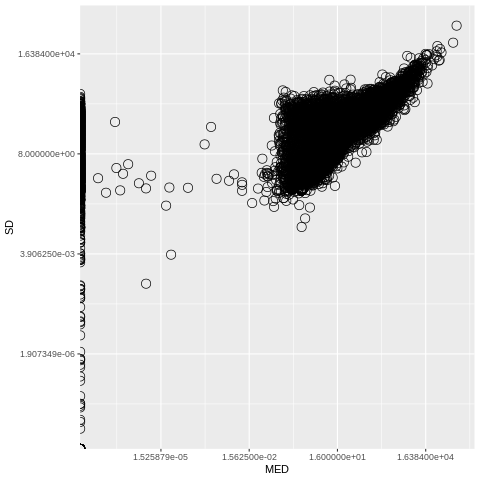

In [ ]:
%%R
 ggplot(myCounts.stats, aes(x=MED, y=SD)) +
  geom_point(shape=1, size=4)+
  scale_x_continuous(trans='log2')+
  scale_y_continuous(trans='log2')

# Make a DGElist from your counts ----

In [ ]:
%%R
myDGEList <- DGEList(Txi_gene$counts)
# take a look at the DGEList object 
myDGEList
#DEGList objects are a good R data file to consider saving to you working directory
save(myDGEList, file = "myDGEList")
#Saved DGEList objects can be easily shared and loaded into an R environment
load(file = "myDGEList")

# use the 'cpm' function from EdgeR to get counts per million

In [ ]:
%%R
cpm <- cpm(myDGEList) 
print(colSums(cpm))
log2.cpm <- cpm(myDGEList, log=TRUE)

# Take a look at the distribution of the Log2 CPM
nsamples <- ncol(log2.cpm)
myColors <- brewer.pal(nsamples, "Paired")

Sample1 Sample2 Sample3 Sample4 
  1e+06   1e+06   1e+06   1e+06 


# 'coerce' your data matrix to a dataframe so that you can use tidyverse tools on it

In [ ]:
%%R
log2.cpm.df <- as.tibble(log2.cpm)
log2.cpm.df
# add your sample names to this dataframe (we lost these when we read our data in with tximport)
colnames(log2.cpm.df) <- metadata$folder
# use the reshape2 package to 'melt' your dataframe (from wide to tall)
log2.cpm.df.melt <- melt(log2.cpm.df)
Log2.cpm.df.melt <- as.tibble(log2.cpm.df.melt)
Log2.cpm.df.melt

R[write to console]: No id variables; using all as measure variables



# A tibble: 142,572 x 2
   variable    value
   <fct>       <dbl>
 1 SRR6914400 -1.09 
 2 SRR6914400  4.98 
 3 SRR6914400 -1.09 
 4 SRR6914400 -1.09 
 5 SRR6914400 -0.448
 6 SRR6914400 -1.09 
 7 SRR6914400 -1.09 
 8 SRR6914400 -1.09 
 9 SRR6914400 -1.09 
10 SRR6914400 -0.445
# … with 142,562 more rows


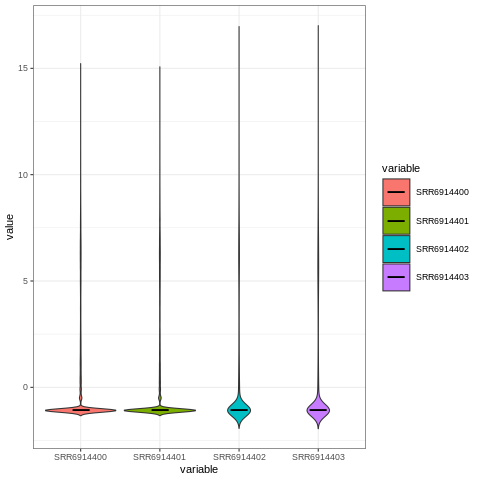

In [ ]:
%%R
ggplot(Log2.cpm.df.melt, aes(x=variable, y=value, fill=variable)) +
geom_violin(trim = FALSE, show.legend = TRUE) +
stat_summary(fun.y = "median", geom = "point", shape = 95, size = 10, color = "black") +
theme_bw()

# Filter your data ----

In [ ]:
%%R
#first, take a look at how many genes or transcripts have no read counts at all
table(rowSums(myDGEList$counts==0)==4)
DGEList <- myDGEList


# now set some cut-off to get rid of genes/transcripts with low counts
keepers <- rowSums(cpm>1)>=2
DGEList.filtered <- DGEList[keepers,]
dim(DGEList.filtered)

log2.cpm.filtered <- cpm(DGEList.filtered, log=TRUE)
log2.cpm.filtered.df <- as.tibble(log2.cpm.filtered) 
colnames(log2.cpm.filtered.df) <- metadata$folder
log2.cpm.filtered.df.melt <- melt(log2.cpm.filtered.df)
log2.cpm.filtered.df.melt <- as.tibble(log2.cpm.filtered.df.melt)

R[write to console]: No id variables; using all as measure variables



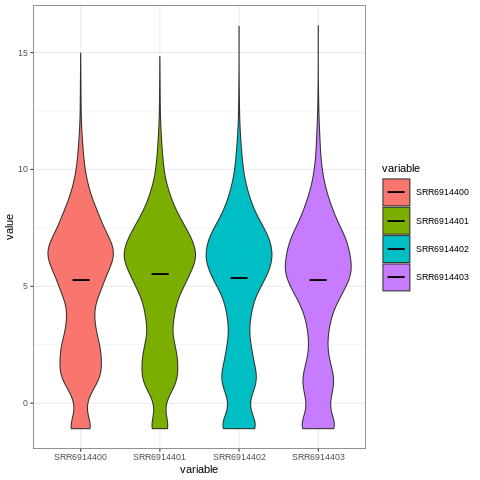

In [ ]:
%%R
ggplot(log2.cpm.filtered.df.melt, aes(x=variable, y=value, fill=variable)) +
geom_violin(trim = TRUE, show.legend = TRUE) +
stat_summary(fun.y = "median", geom = "point", shape = 95, size = 10, color = "black") +
theme_bw()

# Normalize your data ----

In [ ]:
%%R
DGEList.filtered.norm <- calcNormFactors(DGEList.filtered, method = "TMM")
# take a look at this new DGEList object...how has it changed?

# use the 'cpm' function from EdgeR to get counts per million from your normalized data
log2.cpm.filtered.norm <- cpm(DGEList.filtered.norm, log=TRUE)

log2.cpm.filtered.norm.df <- as.tibble(log2.cpm.filtered.norm) 
colnames(log2.cpm.filtered.norm.df) <- metadata$folder
log2.cpm.filtered.norm.df.melt <- melt(log2.cpm.filtered.norm.df)
log2.cpm.filtered.norm.df.melt <- as.tibble(log2.cpm.filtered.norm.df.melt)


R[write to console]: No id variables; using all as measure variables



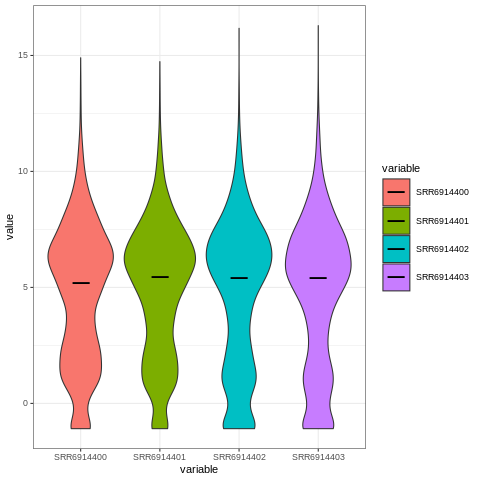

In [ ]:
%%R
ggplot(log2.cpm.filtered.norm.df.melt, aes(x=variable, y=value, fill=variable)) +
geom_violin(trim = TRUE, show.legend = TRUE) +
stat_summary(fun.y = "median", geom = "point", shape = 95, size = 10, color = "black") +
theme_bw()




# Hierarchical clustering ---------------

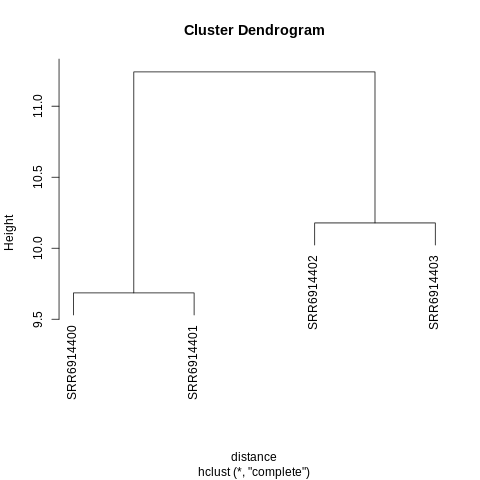

In [ ]:
%%R
#hierarchical clustering can only work on a data matrix, not a data frame
#try using filtered and unfiltered data...how does this change the results
distance <- dist(t(log2.cpm.filtered.norm), method="maximum") #other dist methods are "maximum", "manhattan", "canberra", "binary" or "minkowski"
clusters <- hclust(distance, method = "complete") #other methods are ward.D, ward.D2, single, complete, average
plot(clusters, labels=metadata$folder)


# Pricipal component analysis (PCA) -------------

In [ ]:
%%R
pca.res <- prcomp(t(log2.cpm.filtered.norm), scale.=F, retx=T)
#look at pca.res in environment
ls(pca.res)
summary(pca.res) # Prints variance summary for all principal components.
pca.res$rotation #$rotation shows you how much each gene influenced each PC (called 'scores')
pca.res$x #$x shows you how much each sample influenced each PC (called 'loadings')
#note that these loadings have a magnitude and a direction (this is the basis for making a PCA plot)
pc.var<-pca.res$sdev^2 #sdev^2 gives you the eigenvalues
pc.per<-round(pc.var/sum(pc.var)*100, 1)
pc.per

[1] 40.6 33.5 25.9  0.0


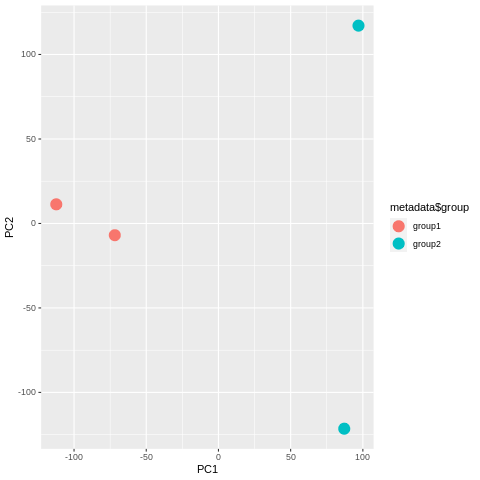

In [ ]:
%%R
pca.res.df <- as.tibble(pca.res$x)
ggplot(pca.res.df, aes(x=PC1, y=PC2, color=metadata$group)) +
geom_point(size=5) +
theme(legend.position="right") 

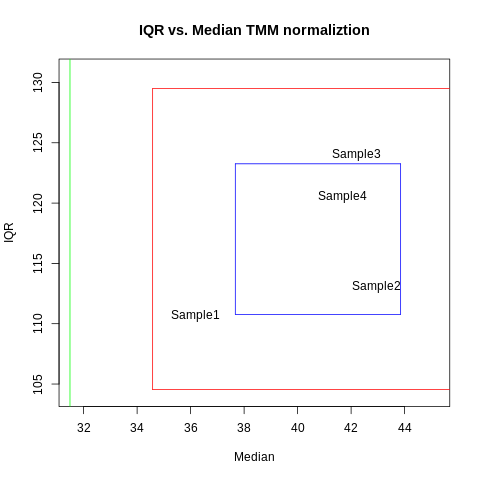

In [ ]:
%%R
#  Make IQR_Median Plots
counts_filtered <- DGEList.filtered.norm$counts
log_counts<-log(counts_filtered+1)
CPM<-cpm(DGEList.filtered.norm)

IQR<-apply(CPM, 2, IQR)
Median<-apply(CPM, 2, median)
diff1<-mean(Median)-min(Median)
diff2<-max(Median)-mean(Median)
diff3<-mean(IQR)-min(IQR)
diff4<-max(IQR)-mean(IQR)

#  These plot settings work for this data and may need to be adjusted for your own data.  
Xlim=c(mean(Median)-2*diff1,mean(Median)+2*diff2)
Ylim=c(mean(IQR)-2*diff3,mean(IQR)+2*diff4)


plot(Median, IQR, main="IQR vs. Median TMM normaliztion", type="n", xlim=Xlim,ylim=Ylim)
text(Median, IQR, labels=names(IQR))

#  Make boxes for StDev.
Median_mean<-mean(Median)  
c_sd1_mean<-sd(Median)
c_sd2_mean<-2*sd(Median)
c_sd3_mean<-3*sd(Median)
IQR_mean<-mean(IQR)
c_sd1_IQR<-sd(IQR)
c_sd2_IQR<-2*sd(IQR)
c_sd3_IQR<-3*sd(IQR)

x0_c<-Median_mean-c_sd1_mean
y0_c<-IQR_mean-c_sd1_IQR
x1_c<-Median_mean+c_sd1_mean
y1_c<-IQR_mean+c_sd1_IQR

x0_c.2<-Median_mean-c_sd2_mean
y0_c.2<-IQR_mean-c_sd2_IQR
x1_c.2<-Median_mean+c_sd2_mean
y1_c.2<-IQR_mean+c_sd2_IQR

x0_c.3<-Median_mean-c_sd3_mean
y0_c.3<-IQR_mean-c_sd3_IQR
x1_c.3<-Median_mean+c_sd3_mean
y1_c.3<-IQR_mean+c_sd3_IQR

segments(x0_c,y0_c, x1=x1_c, y1=y0_c, col="blue")
segments(x0_c,y0_c, x1=x0_c, y1=y1_c, col="blue")
segments(x1_c,y0_c, x1=x1_c, y1=y1_c, col="blue")
segments(x0_c,y1_c, x1=x1_c, y1=y1_c, col="blue")

segments(x0_c.2,y0_c.2, x1=x1_c.2, y1=y0_c.2, col="red")
segments(x0_c.2,y0_c.2, x1=x0_c.2, y1=y1_c.2, col="red")
segments(x1_c.2,y0_c.2, x1=x1_c.2, y1=y1_c.2, col="red")
segments(x0_c.2,y1_c.2, x1=x1_c.2, y1=y1_c.2, col="red")

#  This portion is out of range so I removed it.  
segments(x0_c.3,y0_c.3, x1=x1_c.3, y1=y0_c.3, col="green")
segments(x0_c.3,y0_c.3, x1=x0_c.3, y1=y1_c.3, col="green")
segments(x1_c.3,y0_c.3, x1=x1_c.3, y1=y1_c.3, col="green")
segments(x0_c.3,y1_c.3, x1=x1_c.3, y1=y1_c.3, col="green")


# Sleuth

In [ ]:
%ls

SRR6914400/  SRR6914401/  SRR6914402/  SRR6914403/


# Get TTG file

In [ ]:
%%R
mart <- biomaRt::useMart(biomart = "ENSEMBL_MART_ENSEMBL", dataset = "hsapiens_gene_ensembl")
ttg <- biomaRt::getBM(
  attributes = c("ensembl_transcript_id_version", "transcript_version",
                 "ensembl_gene_id", "external_gene_name", "description",
                 "transcript_biotype"),  mart = mart)
ttg <- dplyr::rename(ttg, target_id = ensembl_transcript_id_version,
                     ens_gene = ensembl_gene_id, ext_gene = external_gene_name)
ttg <- dplyr::select(ttg, c('target_id', 'ens_gene', 'ext_gene'))
head(ttg)

          target_id        ens_gene ext_gene
1 ENST00000387314.1 ENSG00000210049    MT-TF
2 ENST00000389680.2 ENSG00000211459  MT-RNR1
3 ENST00000387342.1 ENSG00000210077    MT-TV
4 ENST00000387347.2 ENSG00000210082  MT-RNR2
5 ENST00000386347.1 ENSG00000209082   MT-TL1
6 ENST00000361390.2 ENSG00000198888   MT-ND1


## create a Sleuth Object 

In [ ]:
%%R
metadata <- dplyr::mutate(metadata,
                          path = file.path(metadata$folder, "abundance.h5"))

In [ ]:
%%R
head(metadata)

   sample     folder  group                    path
1 sample1 SRR6914400 group1 SRR6914400/abundance.h5
2 sample2 SRR6914401 group1 SRR6914401/abundance.h5
3 sample3 SRR6914402 group2 SRR6914402/abundance.h5
4 sample4 SRR6914403 group2 SRR6914403/abundance.h5


In [ ]:
%%R
so_GS <- sleuth_prep(metadata, target_mapping = ttg,gene_mode=TRUE,
                   aggregation_column = 'ext_gene', extra_bootstrap_summary = TRUE,read_bootstrap_tpm = TRUE)

R[write to console]: 'gene_mode' is TRUE. Sleuth will do counts aggregation at the gene level for downstream normalization, transformation, and modeling steps, as well as for plotting and results.

R[write to console]: reading in kallisto results

R[write to console]: dropping unused factor levels

R[write to console]: .
R[write to console]: .
R[write to console]: .
R[write to console]: .
R[write to console]: 

R[write to console]: normalizing est_counts

R[write to console]: 14957 targets passed the filter

R[write to console]: normalizing tpm

R[write to console]: merging in metadata

R[write to console]: aggregating by column: ext_gene

R[write to console]: 5397 genes passed the filter

R[write to console]: summarizing bootstraps

R[write to console]: .
R[write to console]: .
R[write to console]: .
R[write to console]: .
R[write to console]: 



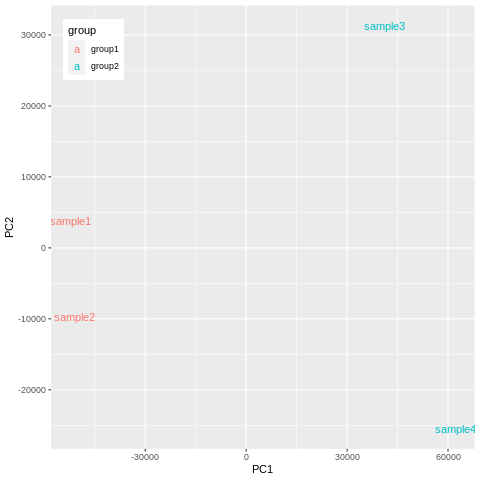

In [ ]:
%%R
plot_pca(so_GS, color_by = 'group', units='scaled_reads_per_base')
new_position_theme <- theme(legend.position = c(0.10, 0.90))
plot_pca(so_GS, color_by = 'group', text_labels = TRUE,units="scaled_reads_per_base") +
  new_position_theme

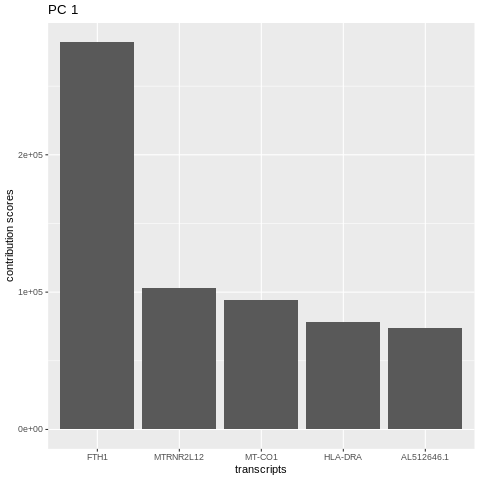

In [ ]:
%%R
plot_loadings(so_GS, pc_input = 1, units='scaled_reads_per_base')

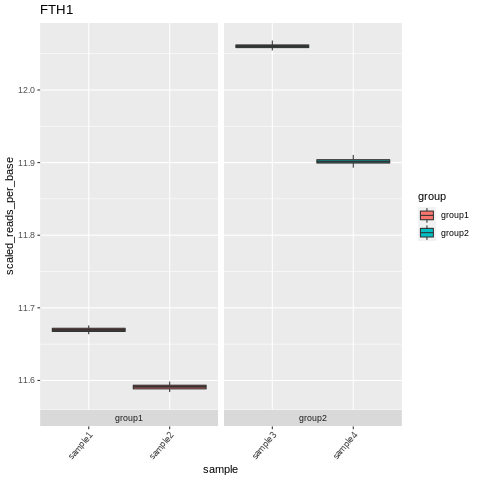

In [ ]:
%%R
plot_bootstrap(so_GS, "FTH1", units = "scaled_reads_per_base", color_by = "group")

In [ ]:
%%
saveRDS(So_GS)